After learning how Bagging and Random Forest reduce variance by aggregating many trees,  
we now turn to a different strategy: **Boosting**.

**Boosting** builds trees **sequentially**, with each new tree focusing on correcting the mistakes made by the previous ones.

*Read section 8.2.3 of the book before using these notes.*

For the exact algorithms underlying the AdaBoost algorithm, check out the papers [`AdaBoostRegressor()`](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=6d8226a52ebc70c8d97ccae10a74e1b0a3908ec1) and [`AdaBoostClassifier()`](https://dept.stat.lsa.umich.edu/~jizhu/pubs/Zhu-SII09.pdf).


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import root_mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier, \
RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import itertools as it
import time as time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display




##  What is AdaBoost?

**AdaBoost** stands for **Adaptive Boosting**.  
It was one of the first boosting algorithms developed.

The core idea behind AdaBoost:

- Train a **weak learner** (usually a shallow decision tree) on the original data.
- Increase the weights of examples that the learner misclassified.
- Train the next learner on this updated, reweighted data.
- Repeat this process, focusing more and more on hard-to-predict examples.

The final prediction is a **weighted combination** of all the weak learners.



##  AdaBoost Intuition

- Easy-to-classify points are **de-emphasized**.
- Hard-to-classify points are **emphasized**.
- Each learner **adapts** to the mistakes made by previous learners — hence "adaptive" boosting.
- **Better-performing learners** are given **higher weight** in the final prediction.

>  Over time, the model becomes better at handling difficult cases.



##  How AdaBoost Works (High-Level Steps)

1. Initialize equal weights for all training examples.
2. Train a weak learner (e.g., decision stump).
3. Evaluate its performance:
   - Increase weights for misclassified points.
   - Decrease weights for correctly classified points.
4. Train the next learner using the updated weights.
5. Repeat for a set number of learners (`n_estimators`).
6. Combine all learners into a final weighted model.



##  Key Hyperparameters in AdaBoost

| Hyperparameter   | Meaning                                              | Typical Values   |
|------------------|------------------------------------------------------|------------------|
| `n_estimators`    | Number of weak learners                             | 50–500           |
| `learning_rate`   | Shrinks each learner’s contribution                 | 0.01–1.0         |
| `estimator`  | Type of weak learner (default: decision stump)      | Shallow trees    |

- **Lowering `learning_rate`** typically requires **more estimators** but improves generalization.



##  AdaBoost for Regression

We will revisit the car dataset we used earlier and evaluate how AdaBoost performs compared to a single decision tree and a bagging ensemble

In [5]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [7]:
X = car.drop(columns=['price'])
y = car['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [9]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_feature])
X_test_encoded = encoder.transform(X_test[categorical_feature])

# Convert the encoded features back to DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_feature))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_feature))

# Concatenate the encoded features with the original numerical features
X_train_final = pd.concat([X_train_encoded_df, X_train[numerical_feature].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df, X_test[numerical_feature].reset_index(drop=True)], axis=1)

### Let's build a adaboost regressor model with default settings

In [ ]:

# build a adaboost regressor model with default parameters
adaboost_regressor = AdaBoostRegressor(random_state=0)

# fit the model
adaboost_regressor.fit(X_train_final, y_train)

# predict the test set
y_pred = adaboost_regressor.predict(X_test_final)

# calculate the mean squared error
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')


# calculate the RMSE and R^2 score for the training data
y_pred_train = adaboost_regressor.predict(X_train_final)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'Adaboost Train RMSE: {rmse_train:.2f}')
print(f'Adaboost Train R^2: {r2_train:.2f}')

# calculate the test score

RMSE: 10239.74
R2 Score: 0.6426025126917443
Adaboost Train RMSE: 10081.26
Adaboost Train R^2: 0.62


#### ❓ Why AdaBoost Perform Worse Here

- **Default base estimator is very weak**:  
  By default, AdaBoost uses **Decision Stumps** (`DecisionTreeRegressor(max_depth=1)`), which are extremely shallow and tend to **underfit** the data badly.

- **Learning rate (`learning_rate=1.0`) is too aggressive**:  
  When using very weak learners, a high learning rate can cause the boosting process to **fail to properly build up model strength**, leading to poor performance.

- **Dataset characteristics**:  
   This dataset is **small** and **not very noisy**, using very shallow trees combined with a high learning rate can cause **severe underfitting**.


What should we do next to reduce bias

* Use deeper Trees as Base Learners
* Tune Learning Rate
* Increase the Number of Estimators


###  Impact of Tree Depth

By default, AdaBoost uses shallow decision stumps (`max_depth=1`) as weak learners.  
However, slightly increasing the tree depth can make each learner more expressive,  
helping the ensemble capture more complex patterns in the data.

This often leads to a **reduction in cross-validation RMSE** and improved model performance,  
especially when the underlying relationships in the data are non-linear.

From our previous exploration, we found that the fully grown decision tree has a depth of 34 on this dataset.  
In this section, we'll experiment with limiting the tree depth and observe how it affects the model's RMSE.  
The goal is to find a depth that balances **bias and variance**, leading to better generalization.


>1 13770.872 (518.361)
>2 9673.586 (398.116)
>3 7783.875 (393.200)
>4 6686.293 (253.234)
>5 5575.918 (176.859)
>6 5106.235 (342.995)
>7 4695.491 (353.584)
>8 4395.372 (366.340)
>9 4143.296 (422.938)
>10 4064.871 (414.840)
>11 3880.994 (433.105)
>12 3831.714 (396.971)
>13 3773.891 (437.190)
>14 3771.442 (425.043)
>15 3769.082 (388.875)
>16 3741.356 (394.563)
>17 3740.153 (415.062)
>18 3721.954 (444.760)
>19 3765.976 (425.594)
>20 3777.496 (425.025)
>21 3827.491 (434.580)
>22 3761.119 (409.760)
>23 3773.776 (429.259)
>24 3763.150 (408.907)
>25 3763.396 (417.512)
>26 3782.507 (405.136)
>27 3791.885 (446.067)
>28 3812.705 (406.567)
>29 3792.121 (445.264)
>30 3780.123 (429.651)
>31 3739.596 (472.987)
>32 3797.480 (426.929)
>33 3754.727 (417.368)


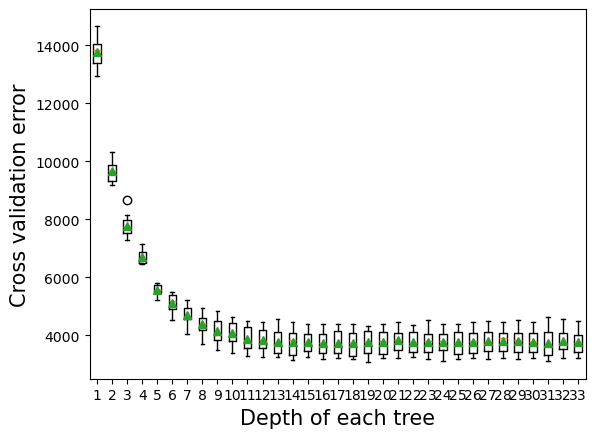

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,34):
        # define base model
        base = DecisionTreeRegressor(max_depth=i)
        # define ensemble model
        models[str(i)] = AdaBoostRegressor(estimator=base,n_estimators=100, learning_rate=0.1, random_state=0)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train_final, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15);

As shown in the plot, very shallow trees (e.g., `max_depth=1` to `3`) result in high cross-validation error due to underfitting.  
As tree depth increases, the model becomes more expressive, and the error drops sharply up to around depth 10.  

Beyond this point, deeper trees offer diminishing returns, and performance stabilizes.  
> 🔍 This suggests that **slightly deeper trees (e.g., depth 5–10)** strike a good balance between model complexity and generalization in AdaBoost.


###  Impact of Learning Rate

In boosting algorithms such as **AdaBoost** or **Gradient Boosting**, the `learning_rate` controls **how much each new tree contributes** to the overall model.

Each new tree makes a correction to the current prediction, and the learning rate scales **how aggressively** that correction is applied.

- 🔺 A **high learning rate** takes **large correction steps** — fast learning, but higher risk of overshooting or overfitting.
- 🔹 A **low learning rate** takes **small correction steps** — more stable, but may underfit unless paired with enough trees.



####  Effect on Performance

| Learning Rate              | Behavior                            | Risk                              |
|----------------------------|-------------------------------------|-----------------------------------|
|  Very Small (e.g., 0.01) | Learns slowly, needs many trees     | Underfitting if not enough trees |
|  Moderate (e.g., 0.1–0.2) | Balanced correction, stable learning | Often optimal                    |
|  Large (e.g., 0.5–1.0)   | Learns quickly, may overshoot       | Overfitting or unstable learning |


>  **Key takeaway**: Small learning rates usually generalize better — especially when combined with more estimators.



>0.01 8877.6 (725.1)
>0.02 8797.2 (656.7)
>0.04 8554.4 (540.3)
>0.08 7988.1 (479.9)
>0.1 7763.7 (345.8)
>0.15 7754.0 (380.3)
>0.2 7862.9 (368.8)
>0.3 8024.6 (345.3)
>0.6 9078.9 (205.6)
>1.0 10508.4 (507.6)


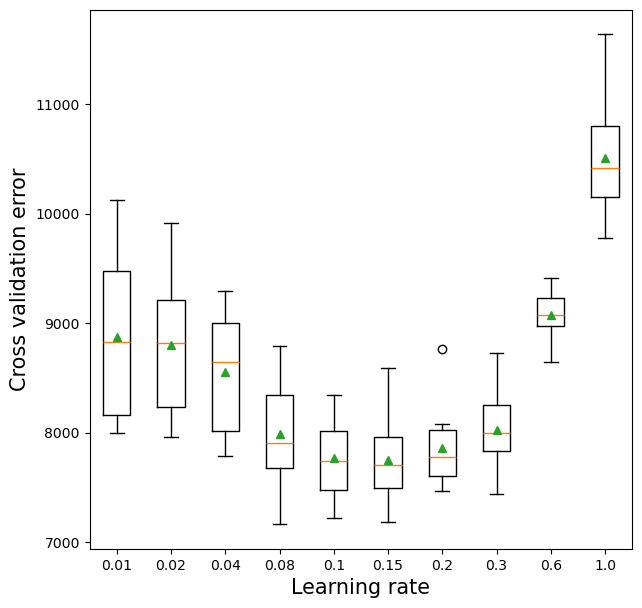

In [12]:
def get_models():
    models = dict()
    learning_rates = [0.01, 0.02, 0.04, 0.08, 0.1, 0.15, 0.2, 0.3, 0.6, 1.0]
    for i in range(len(learning_rates)):
        key = learning_rates[i]
        models[key] = AdaBoostRegressor(learning_rate=learning_rates[i])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train_final, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15);

The plot shows that moderate learning rates (0.1–0.2) yield the best and most stable model performance, while very small or very large values hurt generalization — likely due to underfitting or overfitting.

### Impact of Number of Trees in Boosting

As the number of trees increases in a boosting model, the **prediction bias tends to decrease**, while the **variance may increase**.  

This creates a trade-off:  

- Too few trees → underfitting (high bias)  
- Too many trees → potential overfitting (high variance)

>  There is typically an **optimal number of trees** that minimizes the overall prediction error, which can be identified using cross-validation.


>10 8901.126 (529.620)
>20 8640.382 (495.164)
>30 8328.349 (539.563)
>40 7972.809 (387.803)
>50 7907.280 (359.779)
>60 7927.212 (305.995)
>70 7904.131 (281.108)
>80 7914.196 (295.777)
>90 7917.841 (274.357)
>100 7927.393 (260.542)
>200 8286.386 (180.913)
>300 8884.444 (230.006)
>500 10024.047 (421.340)


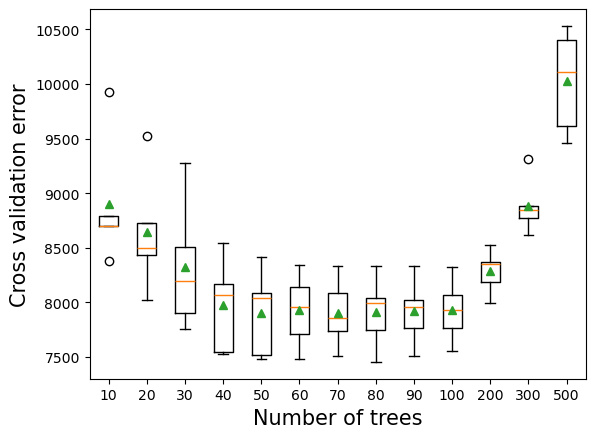

In [13]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 20, 30, 40,  50, 60, 70,  80, 90, 100,  200, 300, 500]
    for n in n_trees:
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1, learning_rate=0.1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train_final, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15);

With a learning rate of 0.1, the validation error initially decreases, then levels off, and eventually starts to increase — indicating that overfitting is beginning to occur

### Tuning Hyperparameters Simultaneously

In the following section, we will use **BayesSearchCV** instead of `GridSearchCV` to efficiently tune multiple hyperparameters at once.  
Unlike grid search, which exhaustively evaluates all combinations, Bayesian optimization intelligently explores the hyperparameter space by learning from previous evaluations.  
This allows us to find a high-performing model using **fewer iterations and less computation**.

In [60]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define the base estimator search space (DecisionTreeRegressor)
base_estimator = DecisionTreeRegressor()

# AdaBoost model (wrapped for BayesSearchCV)
adaboost = AdaBoostRegressor(estimator=base_estimator, random_state=42)

# Search space for tuning
search_space = {
    'estimator__max_depth': Integer(5, 25),
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 2.0, prior='log-uniform')
}

# Set up the BayesSearchCV
opt = BayesSearchCV(
    estimator=adaboost,
    search_spaces=search_space,
    n_iter=50,
    scoring='neg_root_mean_squared_error',  # or use 'r2'
    cv=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
opt.fit(X_train_final, y_train)

# Best parameters
print("Best parameters found:")
print(opt.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [61]:
# Best score
print("Best score (RMSE):")
print(-opt.best_score_)

Best score (RMSE):
3280.273309604182


In [19]:
# evaluate the best model on the test set
best_model = opt.best_estimator_
y_pred_test = best_model.predict(X_test_final)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print(f'Test RMSE: {rmse_test:.2f}')
print(f'Test R^2: {r2_score(y_test, y_pred_test):.2f}')

Test RMSE: 3989.52
Test R^2: 0.95


Below is the plot showing the minimum cross-validated score computed obtained until 'n' hyperparameter values are considered for cross-validation.

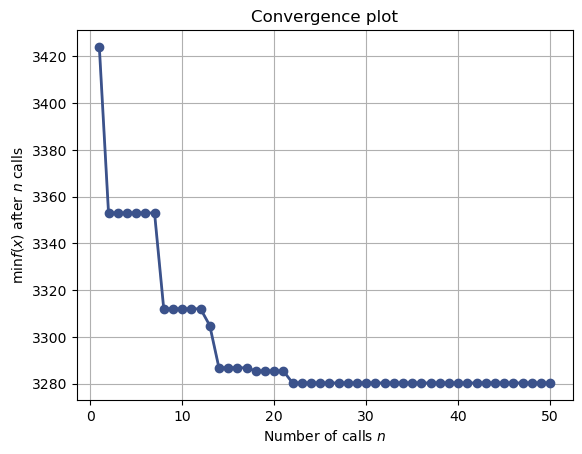

In [63]:
# import plot_convergence from skopt
from skopt.plots import plot_convergence

plot_convergence(opt.optimizer_results_)
plt.show()

In [78]:
# access the full results
results_df = pd.DataFrame(opt.cv_results_)
results_df['mean_test_score'] = -results_df['mean_test_score'] 
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,27.288841,0.743828,0.243362,0.085644,13,0.472627,473,"{'estimator__max_depth': 13, 'learning_rate': ...",-3294.069041,-3813.012426,...,-2756.999972,-2932.996457,-3575.875394,-3939.806709,-3177.591857,-3766.324137,-3573.518290,3424.096527,366.570915,19
1,17.667935,0.272929,0.097709,0.037637,22,1.077792,221,"{'estimator__max_depth': 22, 'learning_rate': ...",-3425.092032,-3911.963174,...,-2779.928592,-2983.762090,-2930.152797,-3924.408565,-3440.000215,-3206.956114,-3554.256617,3353.027977,368.446075,14
2,8.346380,0.144302,0.054507,0.011088,14,1.300194,142,"{'estimator__max_depth': 14, 'learning_rate': ...",-3321.981911,-4164.975787,...,-2725.368888,-2880.655623,-3542.504943,-3951.995509,-3251.140610,-3233.160256,-3651.305989,3403.423338,419.768357,17
3,30.282255,0.495589,0.178685,0.054628,21,0.024859,339,"{'estimator__max_depth': 21, 'learning_rate': ...",-3409.024380,-5096.657461,...,-2763.126306,-3056.556831,-3554.147448,-4526.278591,-3471.156642,-3489.118289,-3832.937027,3671.805682,645.785144,29
4,27.381998,0.592005,0.195445,0.069875,21,0.101840,311,"{'estimator__max_depth': 21, 'learning_rate': ...",-3554.834507,-5030.730461,...,-2786.992358,-3032.669232,-3554.205187,-4512.125597,-3486.494604,-3709.185433,-3678.304514,3702.954168,616.274481,35


#### Analyzing `BayesSearchCV` Results

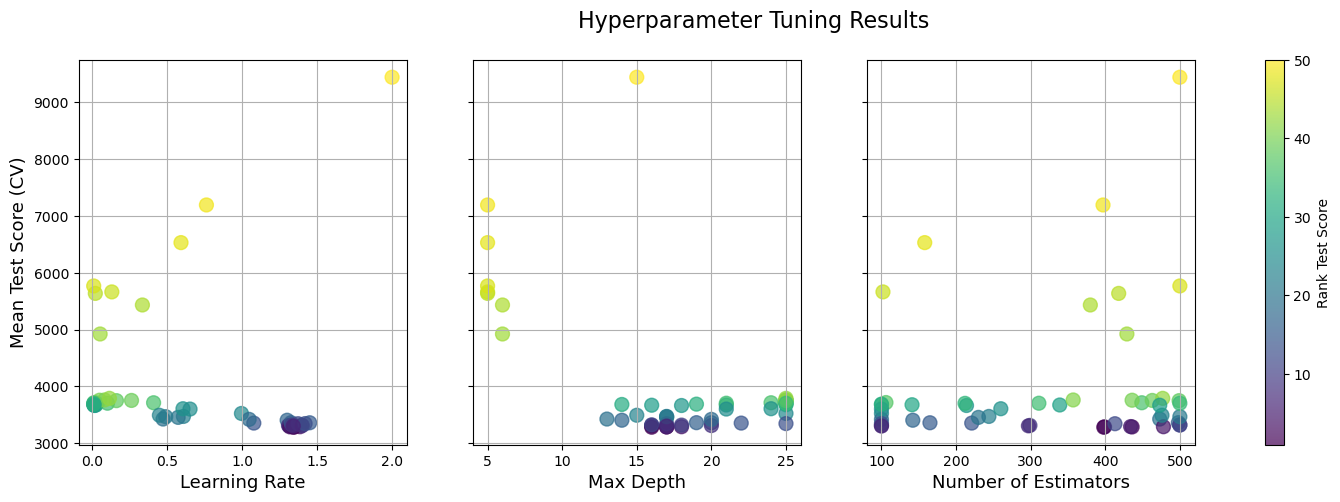

In [79]:
# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# List of hyperparameters and axis labels
params = ['param_learning_rate', 'param_estimator__max_depth', 'param_n_estimators']
labels = ['Learning Rate', 'Max Depth', 'Number of Estimators']

# Plot each subplot
for ax, param, label in zip(axes, params, labels):
    sc = ax.scatter(
        results_df[param],
        results_df['mean_test_score'],
        c=results_df['rank_test_score'],
        cmap='viridis',
        s=100,
        alpha=0.7
    )
    ax.set_xlabel(label, fontsize=13)
    ax.grid(True)

# Set shared y-axis label and title
axes[0].set_ylabel('Mean Test Score (CV)', fontsize=13)
fig.suptitle('Hyperparameter Tuning Results', fontsize=16)

# Add shared colorbar
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), label='Rank Test Score');

3D scatterplot

* Each point is a combination of the 3 hyperparameters.

* Color indicates performance (darker = better).

* You can rotate the 3D plot in Jupyter interactively!

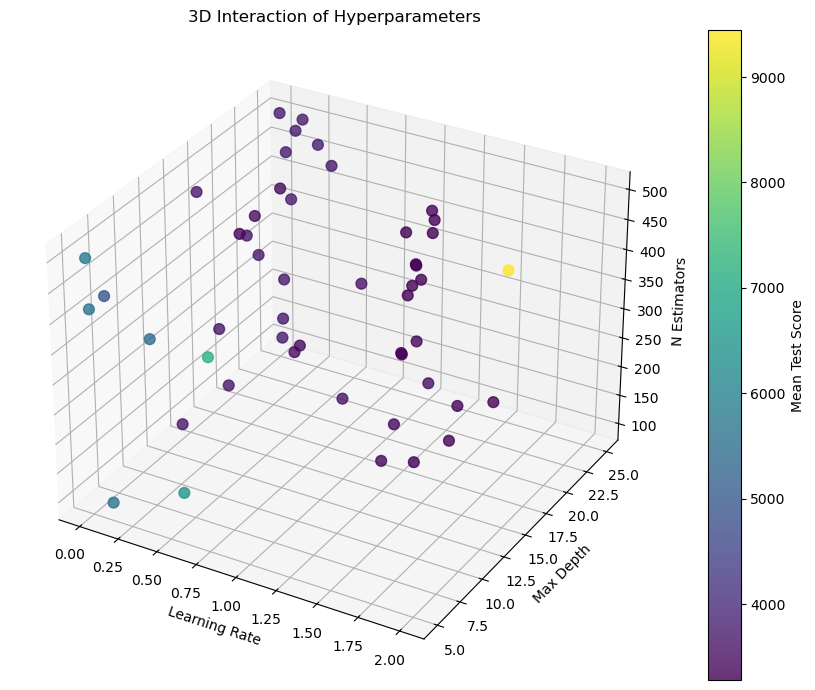

In [80]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    results_df['param_learning_rate'],
    results_df['param_estimator__max_depth'],
    results_df['param_n_estimators'],
    c=results_df['mean_test_score'],
    cmap='viridis',
    s=60,
    alpha=0.8
)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Max Depth')
ax.set_zlabel('N Estimators')
fig.colorbar(p, label='Mean Test Score')
plt.title('3D Interaction of Hyperparameters')
plt.tight_layout()
plt.show()


In [81]:
sorted_results = results_df.copy()
sorted_results = sorted_results[['param_learning_rate', 'param_estimator__max_depth', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score']]  # Convert to RMSE
sorted_results = sorted_results.sort_values(by='rank_test_score')
sorted_results.reset_index(drop=True, inplace=True)
sorted_results[:10] # Display the top 10 results

,param_learning_rate,param_estimator__max_depth,param_n_estimators,mean_test_score,std_test_score,rank_test_score
0,1.346028,16,398,3280.273310,368.679254,1
1,1.339271,17,436,3285.379694,347.295833,2
2,1.318424,17,399,3286.757311,349.655468,3
3,1.386113,18,478,3289.156528,363.813811,4
4,1.342019,17,434,3291.786531,354.169181,5
5,1.340962,17,100,3300.807523,343.109325,6
6,1.313334,16,297,3304.849191,342.465107,7
7,1.401063,20,100,3309.832144,341.978057,8
8,1.309088,16,299,3312.005185,332.872216,9
9,1.396356,18,500,3317.350680,334.036525,10


Let's analyze radeoffs/interactions

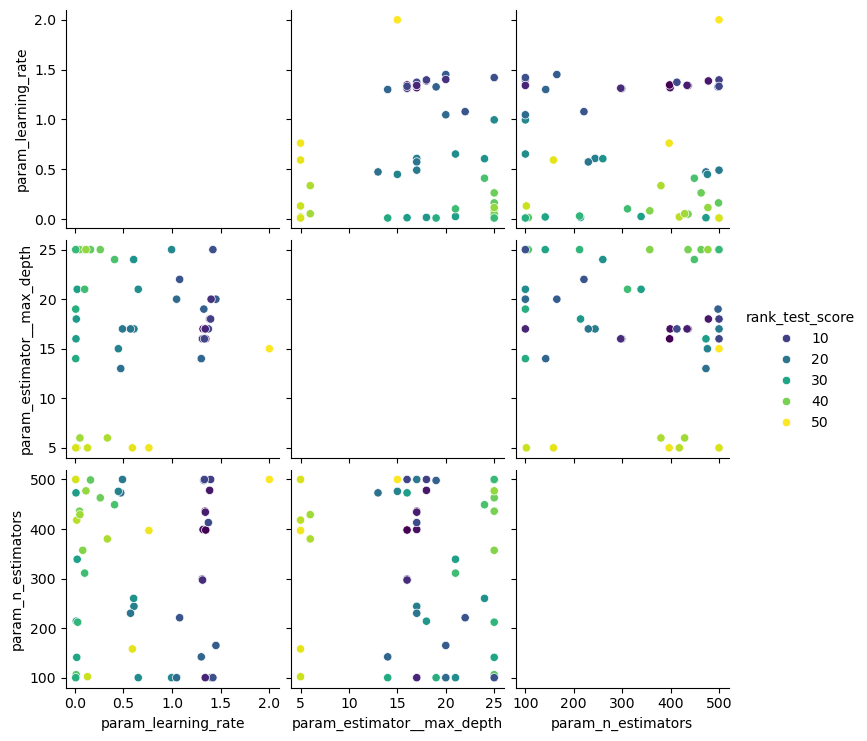

In [69]:
sns.pairplot(
    results_df,
    vars=[
        'param_learning_rate',
        'param_estimator__max_depth',
        'param_n_estimators'
    ],
    hue='rank_test_score',
    palette='viridis'
);


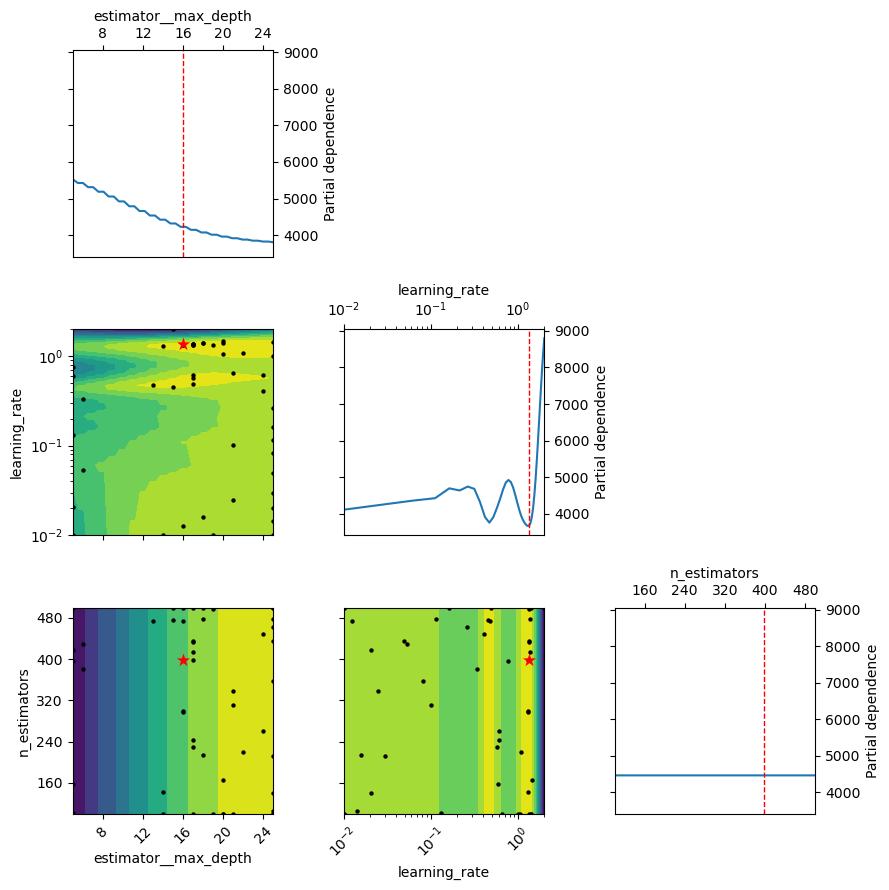

In [70]:
from skopt.plots import plot_objective

plot_objective(opt.optimizer_results_[0], dimensions=None, size = 3)
plt.tight_layout()
plt.show()

### Using Optuna for Hyperparameter Tuning

In [43]:
pip install optuna

   ---------------------------------------- 0.0/386.6 kB ? eta -:--:--
   ------------------ --------------------- 174.1/386.6 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 386.6/386.6 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/231.9 kB ? eta -:--:--
   ---------------------------------------- 231.9/231.9 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/45.8 kB ? eta -:--:--
   ---------------------------------------- 45.8/45.8 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.


Step 1: Import

In [44]:
# import optuna
import optuna

Step 2: Define the Objective Function

In [72]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 0.01, 2.0)
    max_depth = trial.suggest_int("max_depth", 5, 25)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)

    # Define model with trial parameters
    base_estimator = DecisionTreeRegressor(max_depth=max_depth)
    model = AdaBoostRegressor(
        estimator=base_estimator,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )

    # Cross-validation score (negative RMSE)
    score = cross_val_score(model, X_train_final, y_train, scoring="neg_root_mean_squared_error", cv=5)
    return -np.mean(score)


Step 3: Run the study

In [73]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=600)  # 50 trials or 10 min


[I 2025-04-29 18:13:37,366] A new study created in memory with name: no-name-8c1fd49f-a877-442b-99b1-047e129cf2d6
[I 2025-04-29 18:13:55,695] Trial 0 finished with value: 3604.108244895723 and parameters: {'learning_rate': 0.2657114590825371, 'max_depth': 16, 'n_estimators': 118}. Best is trial 0 with value: 3604.108244895723.
[I 2025-04-29 18:14:39,369] Trial 1 finished with value: 3418.989299711666 and parameters: {'learning_rate': 1.3034198280227978, 'max_depth': 19, 'n_estimators': 299}. Best is trial 1 with value: 3418.989299711666.
[I 2025-04-29 18:15:01,876] Trial 2 finished with value: 6675.343723783454 and parameters: {'learning_rate': 1.8424651045294824, 'max_depth': 19, 'n_estimators': 422}. Best is trial 1 with value: 3418.989299711666.
[I 2025-04-29 18:15:51,382] Trial 3 finished with value: 3534.3761450527854 and parameters: {'learning_rate': 0.5334103211344221, 'max_depth': 12, 'n_estimators': 454}. Best is trial 1 with value: 3418.989299711666.
[I 2025-04-29 18:16:17,25

Step 4: Review Best Result

In [74]:
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best RMSE: 3354.0174995460206
Best hyperparameters: {'learning_rate': 1.4283231452601248, 'max_depth': 17, 'n_estimators': 232}


In [75]:
# make a prediction using the best hyperparameters
best_params = study.best_params
base_estimator = DecisionTreeRegressor(max_depth=best_params['max_depth'])
model = AdaBoostRegressor(
    estimator=base_estimator,
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)
# fit the model
model.fit(X_train_final, y_train)
# predict the test set
y_pred = model.predict(X_test_final)
# calculate the mean squared error
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

RMSE: 3524.38
R2 Score: 0.9576611696103872


Step 5: Visualize the Search

In [82]:
optuna.visualization.plot_optimization_history(study).show()

In [83]:
optuna.visualization.plot_param_importances(study).show()


In [84]:
optuna.visualization.plot_parallel_coordinate(study).show()

**Insights:**

* Best Hyperparameter Region:

   * `learning_rate`: ~0.2–0.5
   * `max_depth`: ~7–10
   * `n_estimators`: ~300–450

* Trade-offs:

   * Increasing `n_estimators` improves performance but increases computation time.
   * Lower `learning_rate` values require more estimators to achieve good performance.

* Next Steps:

   * Focus on fine-tuning within the identified ranges for `learning_rate`, `max_depth`, and `n_estimators`.
   * Use these insights to narrow the search space for further optimization.